In [ ]:
#!pip install -q kaggle

#from google.colab import files

#files.upload()

In [1]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d jangedoo/utkface-new

 95% 316M/331M [00:02<00:00, 122MB/s] 
100% 331M/331M [00:02<00:00, 128MB/s]


In [3]:
!unzip utkface-new.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104

 Khai báo thư viện

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [6]:
BASE_DIR = '/content/UTKFace'

In [7]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [8]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['gender'] = image_paths, gender_labels
df.head()

,image,gender
0,/content/UTKFace/45_1_0_20170110151448578.jpg....,1
1,/content/UTKFace/26_1_0_20170117152808211.jpg....,1
2,/content/UTKFace/28_0_3_20170116223108046.jpg....,0
3,/content/UTKFace/60_0_0_20170117162852563.jpg....,0
4,/content/UTKFace/8_0_0_20170104011915424.jpg.c...,0


In [9]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

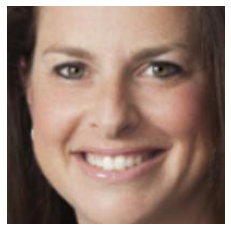

In [43]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

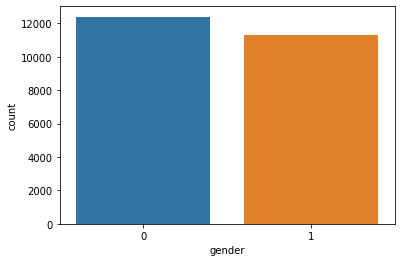

In [11]:
sns.countplot(df['gender'])

Xử lý dữ liệu

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [13]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
X.shape

(23708, 128, 128, 1)

In [15]:
# normalize the images
X = X/255.0

In [16]:
y_gender = np.array(df['gender'])

In [17]:
input_shape = (128, 128, 1)

Tạo model

In [18]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)

model = Model(inputs=[inputs], outputs=output_1)

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

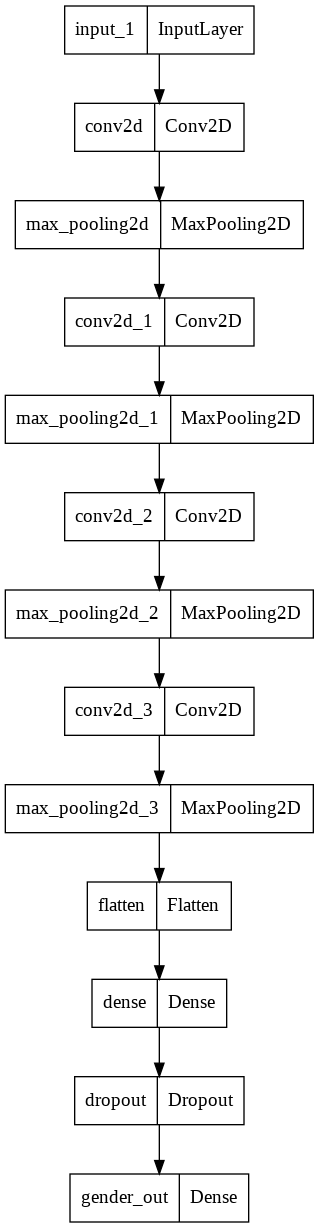

In [19]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
# train model
history = model.fit(x=X, y=y_gender, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 26s 23ms/step - loss: 0.4536 - accuracy: 0.7761 - val_loss: 0.3380 - val_accuracy: 0.8420
Epoch 2/30
593/593 [==============================] - 14s 24ms/step - loss: 0.3174 - accuracy: 0.8577 - val_loss: 0.3347 - val_accuracy: 0.8513
Epoch 3/30
593/593 [==============================] - 13s 21ms/step - loss: 0.2759 - accuracy: 0.8779 - val_loss: 0.2602 - val_accuracy: 0.8851
Epoch 4/30
593/593 [==============================] - 13s 21ms/step - loss: 0.2463 - accuracy: 0.8962 - val_loss: 0.2603 - val_accuracy: 0.8876
Epoch 5/30
593/593 [==============================] - 13s 21ms/step - loss: 0.2243 - accuracy: 0.9051 - val_loss: 0.2587 - val_accuracy: 0.8916
Epoch 6/30
593/593 [==============================] - 13s 21ms/step - loss: 0.2013 - accuracy: 0.9147 - val_loss: 0.2687 - val_accuracy: 0.8823
Epoch 7/30
593/593 [==============================] - 13s 21ms/step - loss: 0.1897 - accuracy: 0.9224 - val_loss: 0.2526 - val_accuracy:

In [29]:
model.save('gender.h5')

Dự đoán bằng 1 hình bất kì 

In [50]:
from keras_preprocessing.image.utils import img_to_array
file_test = load_img('/content/man.jpg',target_size=(128,128),grayscale=True)
file_test = img_to_array(file_test)
file_test /= 255.0
# predict from model
pred = model.predict(file_test.reshape(1, 128, 128, 1).astype('float32'))


Predicted Gender: Male


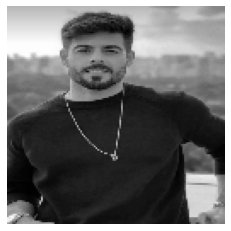

In [51]:
pred_gender = gender_dict[round(pred[0][0])]
print("Predicted Gender:", pred_gender,)

plt.axis('off')
plt.imshow(file_test.reshape(128, 128), cmap='gray');

Đánh giá độ chính xác

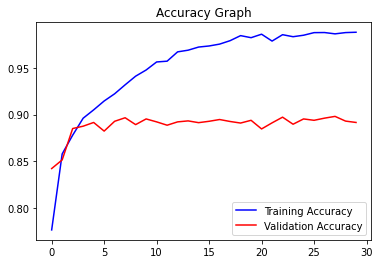

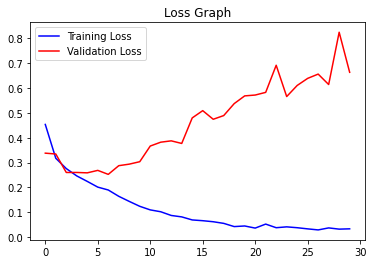

In [42]:
# plot results for gender
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()